In [91]:
#import imageio
!pip install -U imageio
import imageio
!pip install PIL
from PIL import Image
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.cm as colorMap
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from matplotlib.patches import Ellipse
#from PIL import Image
from sklearn import datasets
from sklearn.cluster import KMeans

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
Requirement already up-to-date: imageio in /usr/local/lib/python2.7/site-packages (2.6.1)
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [114]:
def folder(pathname):
    path = os.getcwd()
    file = path + pathname
    df = pd.read_csv(file, delimiter="\t", header=None,index_col=False)
    return df

inputfile = input("Enter the file name: ")
df = folder(str('/' + inputfile))
numpy_df = df.to_numpy()
g_truth = numpy_df[:, 1].astype(int)
real_data = np.delete(numpy_df, [0, 1], axis=1)

Enter the file name: GMM_tab_seperated.txt


In [115]:

X = real_data
X

array([[ 1.372512e+00,  2.404094e+00],
       [ 3.866939e+00,  3.177484e+00],
       [ 2.762927e+00,  2.910694e+00],
       [ 2.005693e+00,  1.143872e+00],
       [ 8.295230e-01,  2.380540e-01],
       [ 8.660000e-02,  4.655930e-01],
       [ 1.599176e+00,  2.478260e+00],
       [-2.371000e-02,  4.098230e-01],
       [-7.754820e-01, -4.336080e-01],
       [-5.276500e-02,  5.319970e-01],
       [-3.519770e-01, -1.586250e-01],
       [ 2.319760e-01,  3.709256e+00],
       [ 5.406330e-01, -8.042530e-01],
       [ 6.486000e-02, -4.779930e-01],
       [-2.108520e-01,  5.089980e-01],
       [ 4.283858e+00,  1.707368e+00],
       [-7.129050e-01,  4.015626e+00],
       [-9.243810e-01, -4.885930e-01],
       [ 2.116176e+00,  2.525056e+00],
       [ 4.024352e+00,  5.128763e+00],
       [ 3.315926e+00,  3.417540e+00],
       [ 4.497200e-01,  4.272531e+00],
       [-3.626140e-01,  3.924018e+00],
       [-5.049430e-01,  4.620809e+00],
       [-1.081407e+00,  3.959850e+00],
       [ 7.079880e-01,  8

In [116]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.pinv(cov)), diff))).reshape(-1, 1)

In [117]:
x0 = np.array([[0.05, 1.413, 0.212], [0.85, -0.3, 1.11], [11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]])
mu = np.mean(x0, axis=0)
cov = np.dot((x0 - mu).T, x0 - mu) / (x0.shape[0] - 1)

y = gaussian(x0, mu=mu, cov=cov)
y

array([[0.00159853],
       [0.00481869],
       [0.00276259],
       [0.0014309 ],
       [0.00143998]])

In [118]:
def initialize_clusters(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans().fit(X)
    mu_k = kmeans.cluster_centers_
    
    pi_k = [0.5,0.5]
    mu_k = [[0,0],[1,1]]
    cov_k = [[[1,1],[1,1]],[[2,2],[2,2]]]
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': pi_k[i],
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

In [119]:
def expectation_step(X, clusters):
    totals = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        gamma_nk = (pi_k * gaussian(X, mu_k, cov_k)).astype(np.float64)
        
        for i in range(X.shape[0]):
            totals[i] += gamma_nk[i]
        
        cluster['gamma_nk'] = gamma_nk
        cluster['totals'] = totals
        
    
    for cluster in clusters:
        cluster['gamma_nk'] /= cluster['totals']

In [120]:
def maximization_step(X, clusters):
    N = float(X.shape[0])
  
    for cluster in clusters:
        gamma_nk = cluster['gamma_nk']
        cov_k = np.zeros((X.shape[1], X.shape[1]))
        
        N_k = np.sum(gamma_nk, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_nk * X, axis=0) / N_k
        
        for j in range(X.shape[0]):
            diff = (X[j] - mu_k).reshape(-1, 1)
            cov_k += gamma_nk[j] * np.dot(diff, diff.T)
            
        cov_k /= N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

In [121]:
def get_likelihood(X, clusters):
    likelihood = []
    sample_likelihoods = np.log(np.array([cluster['totals'] for cluster in clusters]))
    return np.sum(sample_likelihoods), sample_likelihoods

In [122]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)
        
    for i, cluster in enumerate(clusters):
        scores[:, i] = np.log(cluster['gamma_nk']).reshape(-1)
        
    return clusters, likelihoods, scores, sample_likelihoods, history

In [123]:
n_clusters = 2
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X, n_clusters, n_epochs)

Epoch:  1 Likelihood:  -5811.700149398779
Epoch:  2 Likelihood:  -3825.6212908900834
Epoch:  3 Likelihood:  -3754.266247856046
Epoch:  4 Likelihood:  -3730.637799964915
Epoch:  5 Likelihood:  -3720.2682050886974
Epoch:  6 Likelihood:  -3714.483036595375
Epoch:  7 Likelihood:  -3711.231259167172
Epoch:  8 Likelihood:  -3709.4498708312194
Epoch:  9 Likelihood:  -3708.481630146549
Epoch:  10 Likelihood:  -3707.9488884095654
Epoch:  11 Likelihood:  -3707.6494245166423
Epoch:  12 Likelihood:  -3707.4770910523375
Epoch:  13 Likelihood:  -3707.3756437332763
Epoch:  14 Likelihood:  -3707.314670565378
Epoch:  15 Likelihood:  -3707.2773389785025
Epoch:  16 Likelihood:  -3707.2541098538454
Epoch:  17 Likelihood:  -3707.239453432062
Epoch:  18 Likelihood:  -3707.2300958748706
Epoch:  19 Likelihood:  -3707.2240614510406
Epoch:  20 Likelihood:  -3707.2201372617264
Epoch:  21 Likelihood:  -3707.2175674253376
Epoch:  22 Likelihood:  -3707.2158746744662
Epoch:  23 Likelihood:  -3707.214754248294
Epoch:

In [124]:
clusters[0]['gamma_nk']

array([[5.74934885e-02],
       [3.39796619e-04],
       [3.33229821e-03],
       [6.99150161e-01],
       [9.96614225e-01],
       [9.97321241e-01],
       [3.90368726e-02],
       [9.98070371e-01],
       [9.99968898e-01],
       [9.96940348e-01],
       [9.99851698e-01],
       [4.25901215e-05],
       [9.99908856e-01],
       [9.99911307e-01],
       [9.97548120e-01],
       [2.22793941e-03],
       [8.68591783e-07],
       [9.99978747e-01],
       [2.32539013e-02],
       [5.31898022e-07],
       [3.52006847e-04],
       [1.99422454e-06],
       [3.66465705e-06],
       [2.07517033e-08],
       [4.91458735e-07],
       [9.76926846e-01],
       [1.36359094e-04],
       [2.17348371e-03],
       [3.50558208e-03],
       [2.11071725e-08],
       [2.56679554e-03],
       [3.45015769e-06],
       [9.12950433e-01],
       [2.17945058e-05],
       [2.22674211e-10],
       [3.37606633e-03],
       [9.99999839e-01],
       [6.44903358e-03],
       [9.86862892e-01],
       [3.56169453e-03],


In [125]:
scores[0]

array([-2.85608358, -0.05921245])

In [126]:
X[3, 0]

2.005693

In [127]:
np.argmax(scores[4])

0

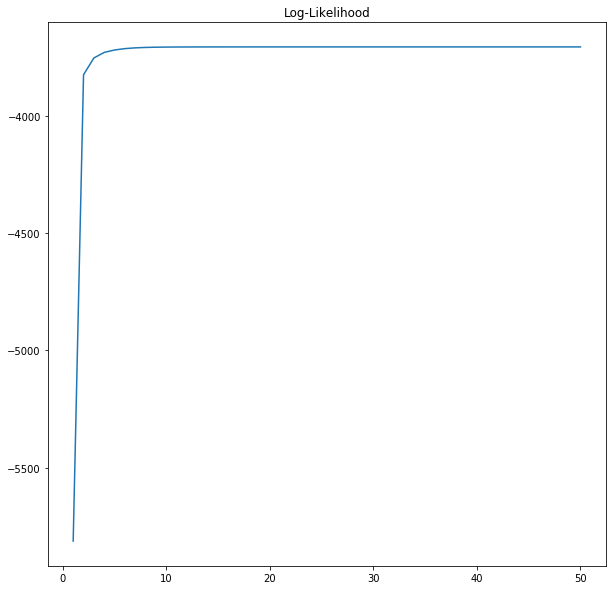

In [128]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), likelihoods)
plt.show()

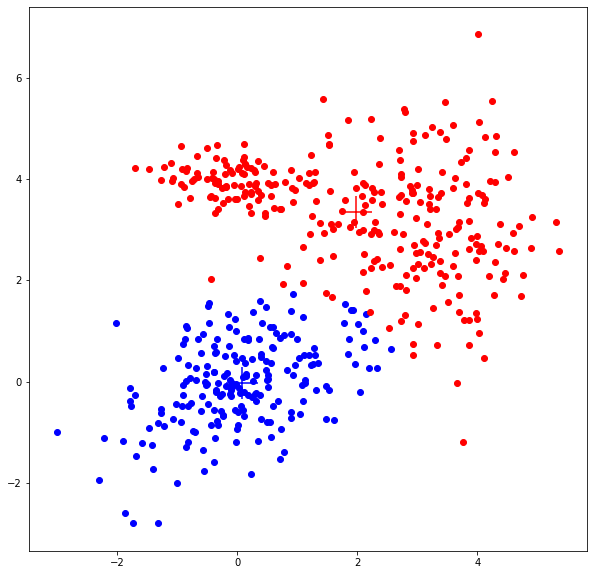

In [129]:
def create_cluster(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
            idx += 1

        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster(X, history, scores)

In [130]:
def getArgMax(value):
    return np.argmax(scores[value])

def validate_count(ground_truth, data_matrix):
    m11 = m00 = m10 = m01 = 0.0
    for i in range(len(ground_truth)):
        if ground_truth[i] == np.argmax(scores[i]):
            if ground_truth[i] == 1:
                m11 = m11 + 1
            else:
                m00 = m00 + 1
            
        else:
            if ground_truth[i] == 1:
                m10 = m10 + 1
            else:
                m01 = m01 + 1
    return m11, m00, m10, m01
    
# Methods which calculate the Coefficients.
def calc_jaquard(m11, m00, m10, m01):
    return (m11 / (m11 + m10 + m01))

def calc_rand(m11, m00, m10, m01):
    return ((m11+m00)/(m11+m00+m10+m01))

m11, m00, m10, m01 = validate_count(g_truth,scores)
print(calc_rand(m11,m00,m10,m01))
print(calc_jaquard(m11, m00, m10, m01))

0.004
0.004


In [131]:
from sklearn.mixture import GaussianMixture
n_clusters = 2
gmm = GaussianMixture(n_components=n_clusters, max_iter=50).fit(X)
gmm_scores = gmm.score_samples(X)

d = pd.DataFrame(X)

print('Means by sklearn:\n', gmm.means_)
print('Scores by sklearn:\n', gmm_scores[0:20])


Means by sklearn:
 [[ 1.97141414  3.36555436]
 [ 0.08905433 -0.01867623]]
Scores by sklearn:
 [-3.49133745 -3.55788702 -3.06463321 -4.00613356 -2.79163087 -2.73894148
 -3.35272643 -2.73432005 -2.88893869 -2.85232289 -2.63772198 -3.43917421
 -3.38037994 -2.71507933 -2.92075055 -4.482845   -4.15574648 -3.01283529
 -3.21523458 -5.9656396 ]


In [132]:
gmm.fit(X)
lab = gmm.predict(X)
d['labels'] = lab
d0 = d[d['labels']==0]
d1 = d[d['labels']==1]

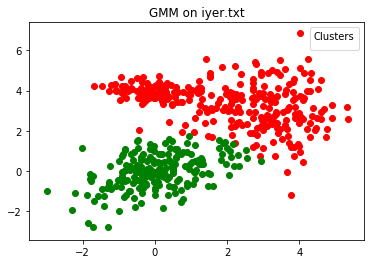

In [133]:
plt.scatter(d0[0],d0[1],c='r')
plt.scatter(d1[0],d1[1],c='g')
legend = list()
classes = np.unique(g_truth)
class_len = len(classes)
colors = colorMap.Set1(np.linspace(0, 1, class_len))
plt.legend(legend, classes,title="Clusters",fancybox="True")
plt.title("GMM on " + "iyer.txt")
plt.show()